In [4]:
import tensorflow as tf
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# ----------------- Step 1: Load and Preprocess Data -----------------

# Dummy function to load images & masks (replace with actual dataset)
def load_images_and_masks(image_dir, mask_dir, img_size=(256, 256)):
    images = []
    masks = []

    for img_name in os.listdir(image_dir):
        img_path = os.path.join(image_dir, img_name)
        mask_path = os.path.join(mask_dir, img_name)  # Assuming same name

        if os.path.exists(mask_path):
            # Load image and mask
            img = cv2.imread(img_path)
            img = cv2.resize(img, img_size) / 255.0  # Normalize

            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            mask = cv2.resize(mask, img_size) / 255.0  # Normalize to 0-1

            images.append(img)
            masks.append(mask)

    images = np.array(images, dtype=np.float32)
    masks = np.array(masks, dtype=np.float32).reshape(-1, img_size[0], img_size[1], 1)  # Add channel

    return images, masks

# Define dataset paths (replace with actual dataset)
image_dir = "road_segmentation/images"
mask_dir = "road_segmentation/masks"

# Load dataset
X, Y = load_images_and_masks(image_dir, mask_dir)

# Split dataset into train, validation, and test
X_train, X_temp, Y_train, Y_temp = train_test_split(X, Y, test_size=0.3, random_state=42)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=42)

print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")

# ----------------- Step 2: Define the U-Net Model -----------------

def build_unet(input_shape=(256, 256, 3)):
    inputs = tf.keras.layers.Input(input_shape)

    # Encoder (Downsampling)
    c1 = tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same')(inputs)
    c1 = tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same')(c1)
    p1 = tf.keras.layers.MaxPooling2D((2,2))(c1)

    c2 = tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='same')(p1)
    c2 = tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='same')(c2)
    p2 = tf.keras.layers.MaxPooling2D((2,2))(c2)

    # Bottleneck
    c3 = tf.keras.layers.Conv2D(256, (3,3), activation='relu', padding='same')(p2)
    c3 = tf.keras.layers.Conv2D(256, (3,3), activation='relu', padding='same')(c3)

    # Decoder (Upsampling with Conv2DTranspose)
    u4 = tf.keras.layers.Conv2DTranspose(128, (3,3), strides=(2,2), padding='same')(c3)
    c4 = tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='same')(u4)
    c4 = tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='same')(c4)

    u5 = tf.keras.layers.Conv2DTranspose(64, (3,3), strides=(2,2), padding='same')(c4)
    c5 = tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same')(u5)
    c5 = tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same')(c5)

    outputs = tf.keras.layers.Conv2D(1, (1,1), activation='sigmoid')(c5)

    model = tf.keras.models.Model(inputs, outputs)
    return model

# Build and compile the model
model = build_unet()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

# ----------------- Step 3: Train the Model -----------------

# Train the model
history = model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    epochs=100,
    batch_size=8
)

print("✅ Training complete!")

# ----------------- Save the Model -----------------
model.save("unet_model.h5")
print("✅ Model saved successfully!")

Train: (21, 256, 256, 3), Val: (5, 256, 256, 3), Test: (5, 256, 256, 3)


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 256, 256, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 256, 256, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 128, 128, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 128, 128, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 64, 64, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_4              │ (None, 128, 128, 128)  │       295,040 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 128, 128, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 128, 128, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_5              │ (None, 256, 256, 64)   │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_30 (Conv2D)              │ (None, 256, 256, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 256, 256, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_32 (Conv2D)              │ (None, 256, 256, 1)    │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,883,329 (7.18 MB)

 Trainable params: 1,883,329 (7.18 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 127s 32s/step - accuracy: 1.8767e-04 - loss: 0.6930 - val_accuracy: 6.1035e-06 - val_loss: 0.6918
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 92s 29s/step - accuracy: 1.1081e-04 - loss: 0.6912 - val_accuracy: 3.0518e-06 - val_loss: 0.6894
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 154s 30s/step - accuracy: 1.9430e-04 - loss: 0.6871 - val_accuracy: 3.0518e-06 - val_loss: 0.6828
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 84s 25s/step - accuracy: 1.5040e-04 - loss: 0.6776 - val_accuracy: 3.0518e-06 - val_loss: 0.6992
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 147s 26s/step - accuracy: 1.7472e-04 - loss: 0.7415 - val_accuracy: 3.0518e-06 - val_loss: 0.6701
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 84s 27s/step - accuracy: 4.3142e-06 - loss: 0.6832 - val_accuracy: 3.0518e-06 - val_loss: 0.6974
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 88s 27s/step - accuracy: 0.0000e+00 - loss: 0.6949 - val_accuracy: 3.0518e-06 - val_loss: 0.6925
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 80s 23s/step - accurac

✅ Training complete!
✅ Model saved successfully!


NameError: name 'load_model' is not defined

✅ Model loaded successfully!
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.0018 - loss: 0.5984
Test Accuracy: 0.0018
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


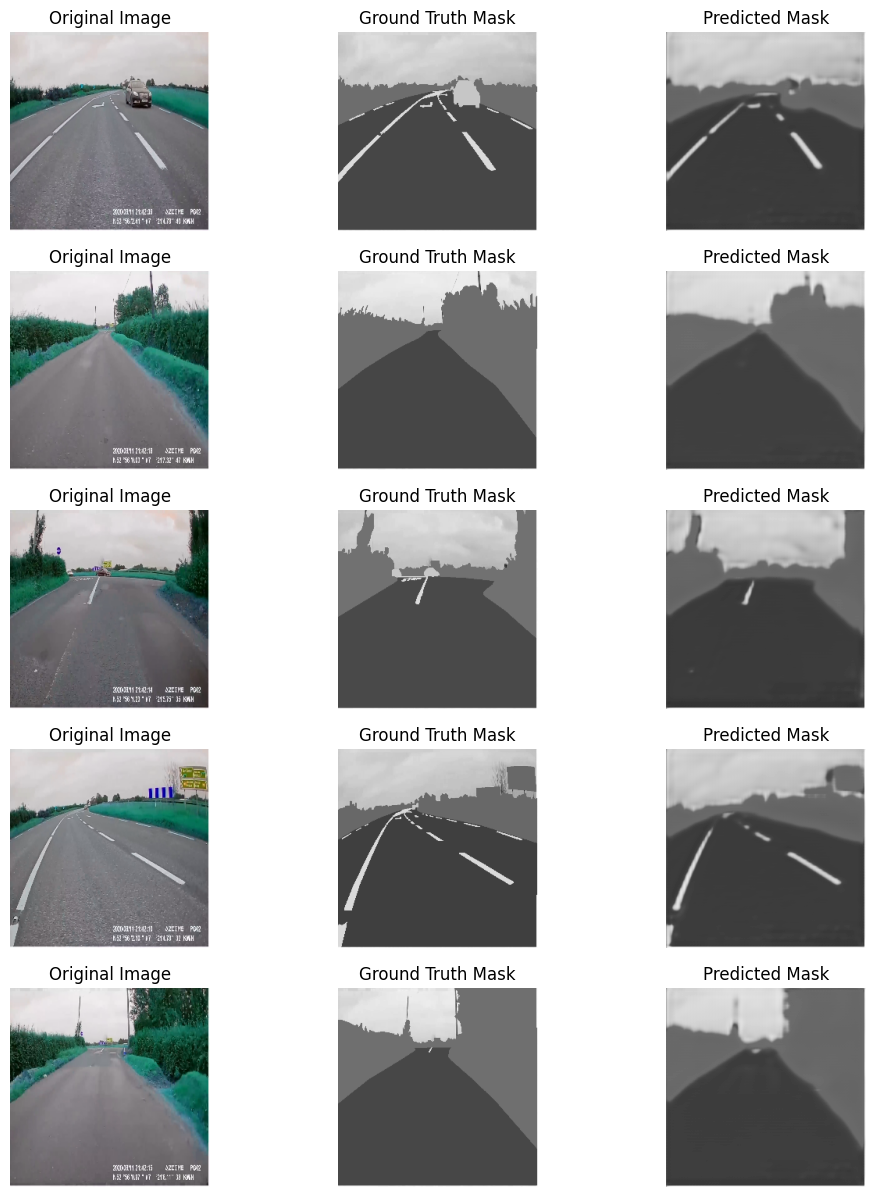

In [5]:
from tensorflow.keras.models import load_model
# ----------------- Load the Model -----------------
model = load_model("unet_model.h5")
print("✅ Model loaded successfully!")

# ----------------- Evaluate the Model -----------------

test_loss, test_acc = model.evaluate(X_test, Y_test)
print(f"Test Accuracy: {test_acc:.4f}")

# ----------------- Step 5: Visualize Predictions -----------------

def plot_predictions(model, X_test, Y_test, num_samples=5):
    indices = np.random.choice(len(X_test), num_samples, replace=False)

    plt.figure(figsize=(12, num_samples * 3))
    for i, idx in enumerate(indices):
        img, true_mask = X_test[idx], Y_test[idx]
        pred_mask = model.predict(img[np.newaxis, ...])[0]

        plt.subplot(num_samples, 3, i * 3 + 1)
        plt.imshow(img)
        plt.title("Original Image")
        plt.axis("off")

        plt.subplot(num_samples, 3, i * 3 + 2)
        plt.imshow(true_mask.squeeze(), cmap="gray")
        plt.title("Ground Truth Mask")
        plt.axis("off")

        plt.subplot(num_samples, 3, i * 3 + 3)
        plt.imshow(pred_mask.squeeze(), cmap="gray")
        plt.title("Predicted Mask")
        plt.axis("off")

    plt.show()

# Plot some predictions
plot_predictions(model, X_test, Y_test)